# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## Resources: 

* Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/ 
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf 

## 0. Get setup

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary


# Try to import the going_modular directory, download it from GitHub if it doesn't work
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent",
)

data_20_percent_path


[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency) 
    * Latency = time for prediction to take place 

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)




## 3. Creating an EffNetB2 feature extractor

Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights 

In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = (
    torchvision.models.EfficientNet_B2_Weights.DEFAULT
)  # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(
    weights=effnetb2_weights
)  # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False


In [7]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


c:\Projects\pytorch-course\venv\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), nn.Linear(in_features=1408, out_features=3, bias=True)
)


In [10]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [11]:
def create_effnetb2_model(
    num_classes: int = 3, seed: int = 42  # default output classes = 3 (pizza, steak, sushi)
):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms


In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)


In [13]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(
    effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=32
)


In [15]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names


(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [16]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5729 | test_loss: 0.7378 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7097 | train_acc: 0.8479 | test_loss: 0.5876 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5858 | train_acc: 0.8958 | test_loss: 0.4865 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4483 | train_acc: 0.9021 | test_loss: 0.4337 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4233 | train_acc: 0.9146 | test_loss: 0.3893 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4420 | train_acc: 0.8875 | test_loss: 0.3511 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4307 | train_acc: 0.8646 | test_loss: 0.3250 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3809 | train_acc: 0.9062 | test_loss: 0.3461 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3766 | train_acc: 0.8854 | test_loss: 0.3122 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3707 | train_acc: 0.8625 | test_loss: 0.2794 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 loss curves

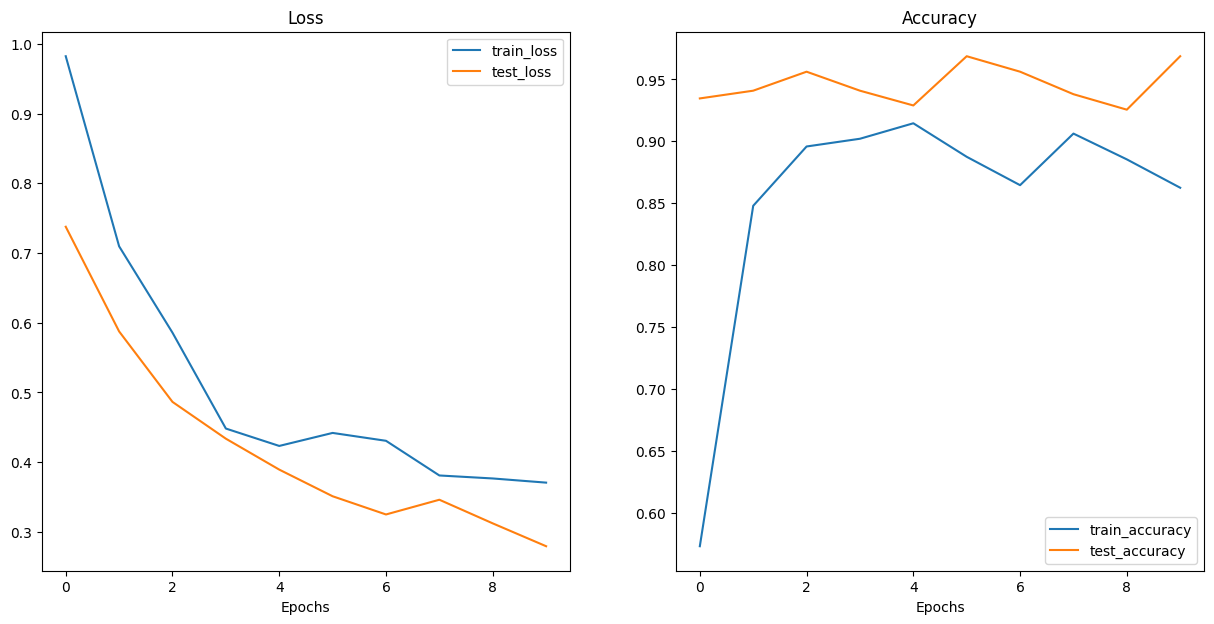

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)


See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 3.5 Saving EffNetB2 feature extractor

In [18]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(
    model=effnetb2,
    target_dir="models",
    model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
)


[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor
Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [19]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
).stat().st_size / (1024 * 1024)
print(
    f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB"
)


Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [20]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params


7705221

In [21]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters": effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size,
}

effnetb2_stats


{'test_loss': 0.27941632866859434,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [22]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads


Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [23]:
def create_vit_model(num_classes: int = 3, seed: int = 42):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

    return model, transforms


In [24]:
vit, vit_transforms = create_vit_model()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
from torchinfo import summary

# Print ViT model summary (uncomment for full output)
summary(
    vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [26]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=vit_transforms, batch_size=32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names


(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor
We're up to model experiment number two: a ViT feature extractor.

In [27]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

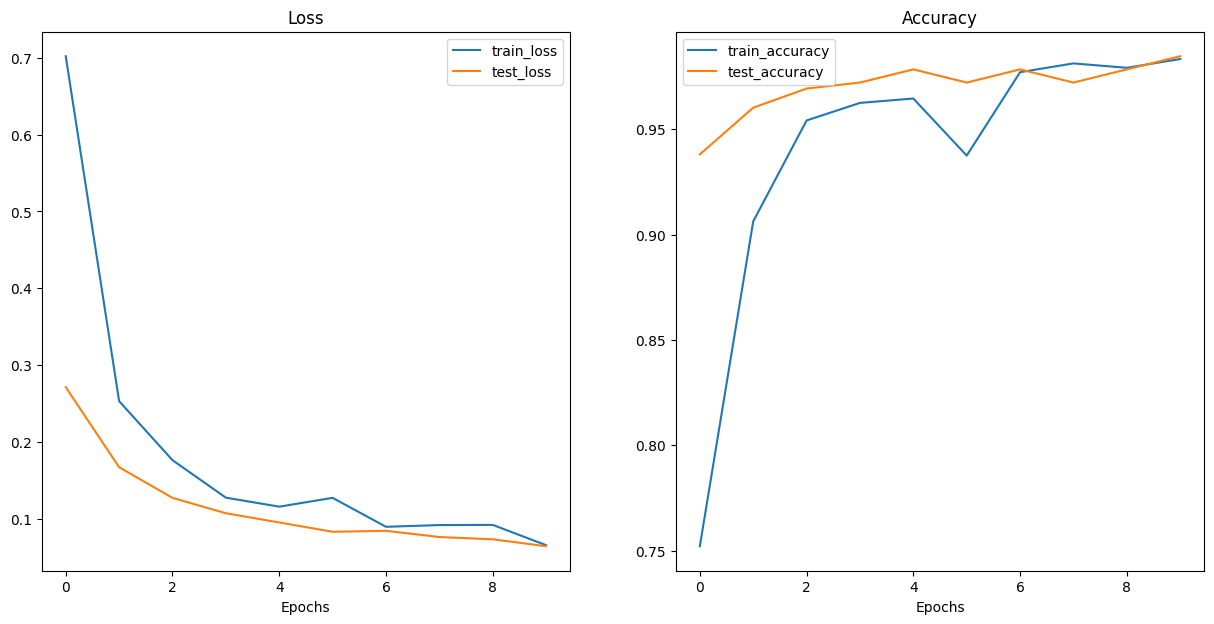

In [28]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)


For more on what an ideal loss curves should look like see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 4.4 Saving ViT feature extractor

In [29]:
# Save model
from going_modular.going_modular import utils

utils.save_model(
    model=vit,
    target_dir="models",
    model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth",
)


[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [30]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path(
    "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"
).stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327.37038707733154 MB


### 4.6 Collecting ViT feature extractor stats

In [31]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params


85800963

In [32]:
# Create ViT statistics dictionary
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "number_of_parameters": vit_total_params,
    "model_size (MB)": pretrained_vit_model_size,
}


In [33]:
vit_stats


{'test_loss': 0.06443454856052995,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image 

Let's work towards making a function called `pred_and_store()` to do so. 

First we'll need a list of test image paths. 

In [34]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

### 5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer. 
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4. 
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [35]:
import pathlib
import torch

from PIL import Image
from timeit import (
    default_timer as timer,
)  # https://docs.python.org/3/library/timeit.html#timeit.default_timer
from tqdm.auto import tqdm
from typing import List, Dict


# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> List[Dict]:
    # 2. Create an empty list (can return a full list of all predictions later).
    pred_list = []

    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
    for path in tqdm(paths):
        # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
        pred_dict = {}

        # 5. Get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer.
        start_time = timer()

        # 7. Open the image using Image.open(path)
        img = Image.open(path)

        # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device)
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
        model = model.to(device)
        model.eval()

        # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # turn logits into predicition probabilities
            pred_label = torch.argmax(
                pred_prob, dim=1
            )  # turn prediction probability into prediction label
            pred_class = class_names[
                pred_label.cpu()
            ]  # hardcode prediction class to be on CPU (Python variables live on CPU)

            # 11. Add the pred prob + pred class to empty dictionary from step 4.
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        # 13. See if the predicted class matches the ground truth class.
        pred_dict["correct"] = class_name == pred_class

        # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
        pred_list.append(pred_dict)

    # 15. Return the list of prediction dictionaries.
    return pred_list


### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`) 


In [36]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device="cpu",
)  # hardcode predictions to happen on CPU


  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
effnetb2_test_pred_dicts[:2]


[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9946,
  'pred_class': 'pizza',
  'time_for_pred': 0.359,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4702,
  'pred_class': 'pizza',
  'time_for_pred': 0.2689,
  'correct': True}]

In [38]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9946,pizza,0.3590,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4702,pizza,0.2689,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9917,pizza,0.2490,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7086,pizza,0.2713,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7623,pizza,0.2651,True


In [39]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()


correct
True     145
False      5
Name: count, dtype: int64

In [40]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")


EffNetB2 average time per prediction: 0.2305


> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [41]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats


{'test_loss': 0.27941632866859434,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.2305}

### 5.3 Making and timing predictions with ViT 

In [42]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device="cpu",
)  # hardcode device to CPU because not sure if GPU available when we deploy


  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]


[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.6085,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.3929,
  'correct': True}]

In [44]:
# Turn vit_test_pred_dicts
import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.6085,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.3929,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.4131,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.3933,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.3822,True


In [45]:
# See how many correct
vit_test_pred_df.correct.value_counts()


correct
True     148
False      2
Name: count, dtype: int64

In [46]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")


ViT average time per prediction: 0.3783


In [47]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats


{'test_loss': 0.06443454856052995,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.3783}

## 6. Comparing model results, prediction times and size

In [48]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.279416,96.88,7705221,29.863233,0.2305,EffNetB2
1,0.064435,98.47,85800963,327.370387,0.3783,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2 

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [49]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(
    data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
    columns=["ViT to EffNetB2 ratios"],
).T


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.230604,1.016412,11.135432,10.962323,1.641215


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib: 
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on. 
4. Create a legend based on the model sizes (`model_size (MB)`).

In [50]:
df


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.279416,96.88,7705221,29.863233,0.2305,EffNetB2
1,0.064435,98.47,85800963,327.370387,0.3783,ViT


In [51]:
import matplotlib

matplotlib.__version__


'3.7.1'

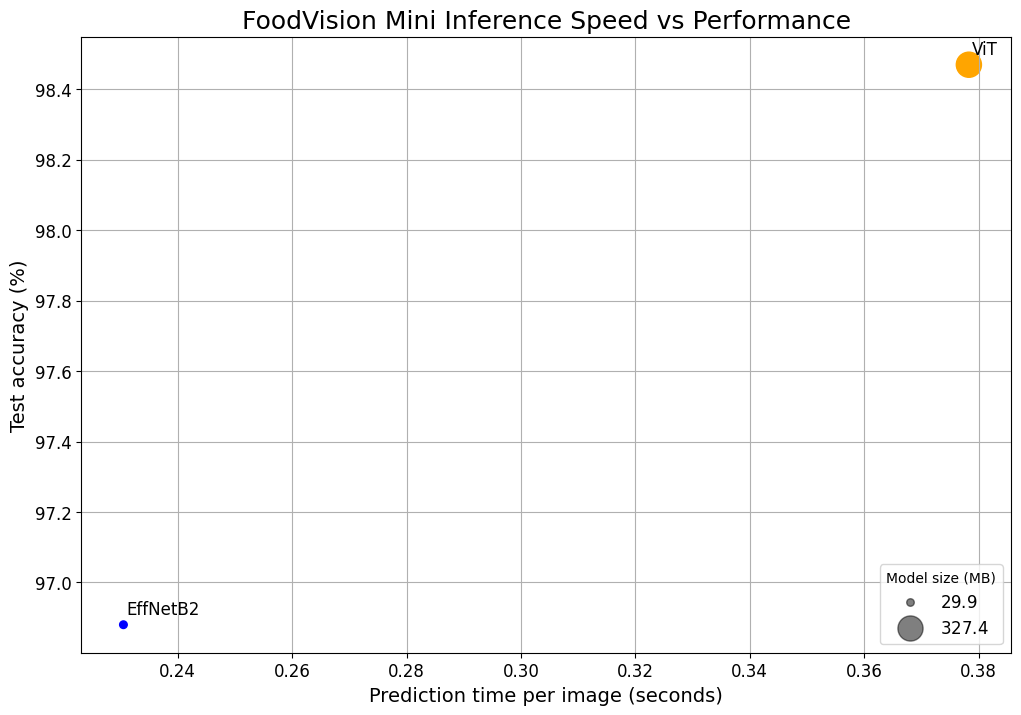

In [52]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    data=df, x="time_per_pred_cpu", y="test_acc", c=["blue", "orange"], s="model_size (MB)"
)

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(
        text=row[
            "model"
        ],  # note: in some versions of Matplotlib, this may need to be "text" rather than "s"
        xy=(row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.03),
        size=12,
    )

# 4. Create a legend based on the model sizes (model_size (MB)).
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(
    handles, labels, loc="lower right", title="Model size (MB)", fontsize=12
)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")


## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio? 

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://gradio.app/ 

For FoodVision Mini, we're going to be working towards building something like this: https://huggingface.co/spaces/mrdbourke/foodvision_mini 



In [53]:
import gradio as gr

print(f"Gradio version: {gr.__version__}")


Gradio version: 3.32.0
